In [2]:
import sys, os
import pandas as pd
import numpy as np
import os
import cv2
import numpy as np
from keras.preprocessing import image
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization,AveragePooling2D
from keras.losses import categorical_crossentropy
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.models import model_from_json
from keras.utils import np_utils
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [3]:
df=pd.read_csv('fer2013.csv')

print(df.info())
print(df["Usage"].value_counts())

print(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35887 entries, 0 to 35886
Data columns (total 3 columns):
emotion    35887 non-null int64
pixels     35887 non-null object
Usage      35887 non-null object
dtypes: int64(1), object(2)
memory usage: 841.2+ KB
None
Training       28709
PrivateTest     3589
PublicTest      3589
Name: Usage, dtype: int64
   emotion                                             pixels     Usage
0        0  70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...  Training
1        0  151 150 147 155 148 133 111 140 170 174 182 15...  Training
2        2  231 212 156 164 174 138 161 173 182 200 106 38...  Training
3        4  24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...  Training
4        6  4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...  Training


In [4]:
X_train,train_y,X_test,test_y=[],[],[],[]

for index, row in df.iterrows():
    val=row['pixels'].split(" ")
    try:
        if 'Training' in row['Usage']:
           X_train.append(np.array(val,'float32'))
           train_y.append(row['emotion'])
        elif 'PublicTest' in row['Usage']:
           X_test.append(np.array(val,'float32'))
           test_y.append(row['emotion'])
    except:
        print(f"error occured at index :{index} and row:{row}")


num_features = 64
num_labels = 7
batch_size = 64
epochs = 30
width, height = 48, 48


X_train = np.array(X_train,'float32')
train_y = np.array(train_y,'float32')
X_test = np.array(X_test,'float32')
test_y = np.array(test_y,'float32')

train_y=np_utils.to_categorical(train_y, num_classes=num_labels)
test_y=np_utils.to_categorical(test_y, num_classes=num_labels)

#cannot produce
#normalizing data between oand 1
X_train -= np.mean(X_train, axis=0)
X_train /= np.std(X_train, axis=0)

X_test -= np.mean(X_test, axis=0)
X_test /= np.std(X_test, axis=0)

X_train = X_train.reshape(X_train.shape[0], 48, 48, 1)

X_test = X_test.reshape(X_test.shape[0], 48, 48, 1)

# print(f"shape:{X_train.shape}")
##designing the cnn
#1st convolution layer
model = Sequential()

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', input_shape=(X_train.shape[1:])))
model.add(Conv2D(64,kernel_size= (3, 3), activation='relu'))
# model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2), strides=(2, 2)))
model.add(Dropout(0.5))

#2nd convolution layer
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Conv2D(64, (3, 3), activation='relu'))
# model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2), strides=(2, 2)))
model.add(Dropout(0.5))

#3rd convolution layer
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(Conv2D(128, (3, 3), activation='relu'))
# model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2), strides=(2, 2)))

model.add(Flatten())

#fully connected neural networks
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.2))


model.add(Dense(num_labels, activation='softmax'))

In [5]:
#Compliling the model
model.compile(loss=categorical_crossentropy,
              optimizer=Adam(),
              metrics=['accuracy'])

In [ ]:
#Training the model
model.fit(X_train, train_y,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(X_test, test_y),
          shuffle=True)


#Saving the  model to  use it later
fer_json = model.to_json()
with open("fer.json", "w") as json_file:
    json_file.write(fer_json)
model.save_weights("fer.h5")

In [7]:
#load model
model = model_from_json(open("fer.json", "r").read())
#load weights
model.load_weights('fer.h5')
face_haar_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

In [8]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 46, 46, 64)        640       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 44, 44, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 22, 22, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 22, 22, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 20, 20, 64)        36928     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 18, 18, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 9, 9, 64)         

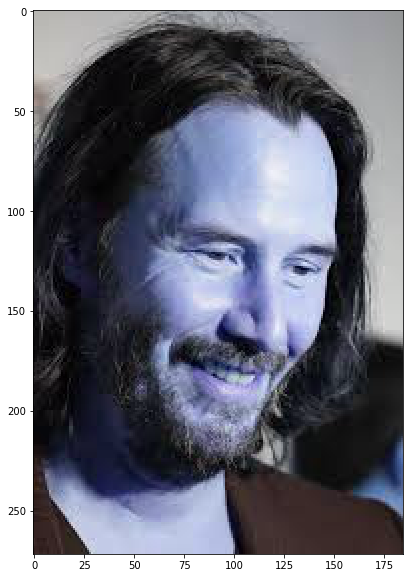

In [26]:
IMG_SIZE=100
#open image here
path = './Smiling_Keanu.jpg'
test_img2 = cv2.imread(path)
plt.figure(figsize = (20,10))
plt.axis('on')
plt.imshow(test_img2)

In [27]:
face_haar_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
gray_img= cv2.cvtColor(test_img2, cv2.COLOR_BGR2GRAY)
faces_detected = face_haar_cascade.detectMultiScale(gray_img, 1.32, 5)

for (x,y,w,h) in faces_detected:
        cv2.rectangle(test_img2,(x,y),(x+w,y+h),(255,0,0),thickness=7)
        roi_gray=gray_img[y:y+w,x:x+h]#cropping region of interest i.e. face area from  image
        roi_gray=cv2.resize(roi_gray,(48,48))
        img_pixels = image.img_to_array(roi_gray)
        img_pixels = np.expand_dims(img_pixels, axis = 0)
        img_pixels /= 255

        predictions = model.predict(img_pixels)

        #find max indexed array
        max_index = np.argmax(predictions[0])

        emotions = ('angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral')
        predicted_emotion = emotions[max_index]

        cv2.putText(test_img2, predicted_emotion, (int(x), int(y)), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,255), 2)

        resized_img = cv2.resize(test_img2, (1000, 700))

        filename = 'savedImage.jpg'
        cv2.imwrite(filename, test_img2) 
        
        #open savedImage.jpg


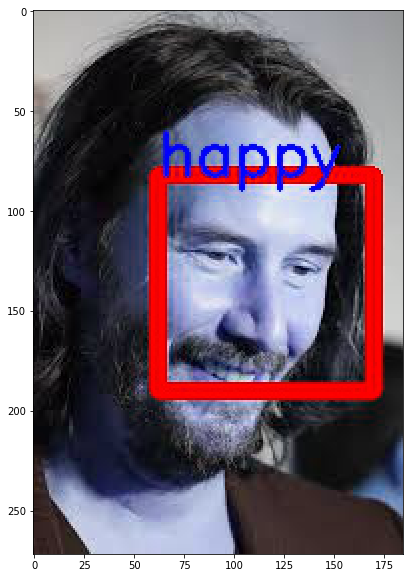

In [28]:
path = './savedImage.jpg'
test_img2 = cv2.imread(path)

plt.figure(figsize = (20,10))
plt.axis('on')
plt.imshow(test_img2)

***
## Video Stream:

In [19]:
import cv2
import sys

cascPath = sys.argv[1]
faceCascade = cv2.CascadeClassifier(cascPath)

video_capture = cv2.VideoCapture(0)

while True:
    # Capture frame-by-frame
    ret, frame = video_capture.read()

    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    faces = faceCascade.detectMultiScale(
        gray,
        scaleFactor=1.1,
        minNeighbors=5,
        minSize=(30, 30),
        flags=cv2.CV_HAAR_SCALE_IMAGE
    )

    # Draw a rectangle around the faces
    for (x, y, w, h) in faces:
        cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 255, 0), 2)

    # Display the resulting frame
    cv2.imshow('Video', frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# When everything is done, release the capture
video_capture.release()
cv2.destroyAllWindows()

error: OpenCV(3.4.2) /tmp/build/80754af9/opencv-suite_1535558553474/work/modules/imgproc/src/color.hpp:253: error: (-215:Assertion failed) VScn::contains(scn) && VDcn::contains(dcn) && VDepth::contains(depth) in function 'CvtHelper'


# To Do:

* Fix error (OpenCV).
* Find a way to deploy the model using the Webcam.